In [345]:
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd


class ModelBootstrap(BaseEstimator, ClassifierMixin):
    
    def __init__(self, estimator, n_boot = 100):
        """
        A class to calibrate binary classifiers and calculate confidence intervals for the predictions.

        estimator:    an estimator with .fit and .predict methods, such as sk-learn classifiers.

        n_boot (int): Number of bootstrap resamples used to estimate the confidence intervals. default: 100

        """
        self.estimator = estimator
        
        if type(n_boot) != int or n_boot < 0:
            raise Warning('n_boot must be an integer larger than 0')
        self.n_boot = n_boot
        
        self.b_estimators = []
        
    def fit(self, X, y, calibration_cv = None, boot_size = None):
        """
        A method to fit a calibrated estimator and n_boot bootstrapped estimators.
        
        X: Numpy array or Pandas dataframe of shape (samples, features).
        
        y: Numpy array of shape (samples,). Binary classifications.
        
        calibration_cv: int, cross-validation generator for sk-learn CalibratedClassifierCV.
                        see: https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
        
        boot_size:    None or int. if None, each resampled dataset will be the same size as the original dataset. 
                      Otherwise, each resampled dataset will include boot_size samples. default: None
        """
        
        if type(X) == pd.core.frame.DataFrame:
            X = X.to_numpy()
            
        self.calibration_cv = calibration_cv
        
        # Main estimator:
        self.calibrated_estimator = CalibratedClassifierCV(base_estimator = self.estimator, cv = self.calibration_cv)
        self.calibrated_estimator.fit(X, y)
        
        # Bootstrap estimators:
        self.boot_size = boot_size
        if self.boot_size == None:
            self.boot_size = X.shape[0]
        
        self.b_estimators = []

        for j in trange(self.n_boot):
            b_idx = np.random.choice(X.shape[0], size = self.boot_size)
            X_resampled = X[b_idx]
            y_resampled = y[b_idx]
            
            partial_estimator = CalibratedClassifierCV(base_estimator = self.estimator, cv = self.calibration_cv)
            partial_estimator.fit(X_resampled, y_resampled)
            self.b_estimators.append(partial_estimator)
            
    def predict(self, X, ci = 95):
        """
        A method to predict a fitted bootstrap model.
        
        X:  Numpy array or Pandas dataframe of shape (samples, features).
        
        ci: Size of the confidence interval that will be calculated.
            integer between 0 and 100, exclusive. deafult: 95.
        """

        if type(X) == pd.core.frame.DataFrame:
            X = X.to_numpy()  
        
        # verify the class if fitted:
        if not self.b_estimators:
            raise Warning('Use fit method first')
        
        if type(ci) != int:
            raise Warning('ci must be an integer between 0 and 100 exclusive')
        elif ci <= 0 or ci >= 100:
            raise Warning('ci must be an integer between 0 and 100 exclusive') 
        ci = (1 - ci / 100) / 2
        
        preds = np.zeros((self.n_boot, X.shape[0]))
        y_pred = self.calibrated_estimator.predict_proba(X)[:,1]
        
        for j, est in enumerate(tqdm(self.b_estimators)):
            b_y_pred = est.predict_proba(X)[:,1]
            preds[j] = b_y_pred
        
        lower_bounds = np.quantile(preds, ci, axis = 0)
        upper_bounds = np.quantile(preds, 1 - ci, axis = 0)
        
        return(y_pred, lower_bounds, upper_bounds)
    
        
    def plot_predict(self, X, y_true = None, ci = 95, threshold = 0.5, n_samples = 'all'):
        """    
        X:   Numpy array or Pandas dataframe of shape (samples, features).
        
        y (optional):   Numpy array of shape (samples,). Binary predictions of classifier.
                        If given, plot will descrimnate samples by the true value. Otherwise, y_pred will be calculated,
                        and samples will be marked according to prediction.
                                                
        ci: int between 0 and 100 (exclusive). Confidence intervals to be calculated, in case X is given. default: 95.
        
        threshold: float between 0.0 and 1.0. Threshold for classifying predictions. default: 0.5.
        
        n_samples:  'all' or an integer <= number of samples. If 'all', all samples will be plotted. Otherwise, n_samples 
                    randomly selected samples will be plotted.
                    
        ---
        if y_true is not provided, given, this method will return the prediction outputs (y_pred, lower_bound, upper_bound). 
        Otherwise will return None.
        
        y_pred: Numpy array of shape (samples,). Binary predictions of classifier.
        
        lower_bound: Numpy array of shape (samples, ). Lower-bound values of y.
        
        upper_bound: Numpy array of shape (samples, ). Upper-bound values of y.
        """

        if type(X) == pd.core.frame.DataFrame:
            X = X.to_numpy()  

        r = False
        y_true = np.array(y_true)
        if not y_true.any():
            y_true = np.zeros(X.shape[0])
            r = True

        # verify the class if fitted:
        if not self.b_estimators:
            raise Warning('Use fit method first')

        y_pred, lower_bound, upper_bound = self.predict(X, ci = ci)
        y_binary = (y_pred > threshold).astype(int)
        results = np.vstack([y_pred, lower_bound, upper_bound, y_true, y_binary]).T

        # unless n_samples = 'all', create a sub-sample for plotting with size = n_samples
        if n_samples != 'all':
            if type(n_samples) != int or n_samples > X.shape[0]:
                raise Warning("n_samples should be 'all' or an integer <= number of samples")
            else:
                idx = np.random.choice(X.shape[0], size = n_samples)
        else:
            idx = np.arange(X.shape[0])

        # mask n_samples samples for plotting.
        results = results[idx]
        order = np.argsort(results[:,0])
        results = results[order]

        # plot predictions with errorbars
       
        results = pd.DataFrame(results, columns = ['y_pred', 'lower_bound', 'upper_bound', 'y_true', 'y_binary'])
        results['error_lb'] = results['y_pred'] - results['lower_bound']
        results['error_ub'] = results['upper_bound'] - results['y_pred']
        
        if r:
            results['y_true'] = results['y_binary']
            
        fig, ax = plt.subplots(figsize = (15,5))
        plt.grid()
        for j in results.y_true.unique():
            class_ = np.where(results['y_true'] == j)[0]

            ax.errorbar(class_, results.loc[class_]['y_pred'], 
                        yerr = [results.loc[class_]['error_lb'].values, results.loc[class_]['error_ub'].values],
                        fmt = 'o',
                        capsize=3,
                        alpha = 0.4
                       )
            ax.scatter(class_, results.loc[class_]['y_pred'], label = j)
        
        ax.hlines(threshold, 0, idx.shape[0], color = 'black', ls = '--', label = 'Threshold') 
        ax.legend(fontsize = 14) ; ax.set_ylim(-0.05,1.05) ; ax.set_ylabel('prob') ; ax.set_xlabel('sample') ; 
        if r:
            ax.legend().set_title('Predicted label:')
        else:
            ax.legend().set_title('True label:')
        
        if r:
            return(y_pred, lower_bound, upper_bound) 


# Example
### Titanic dataset

In [346]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [347]:
df_tit = pd.read_csv("titanic_train.csv")
df_tit["Sex"] = df_tit["Sex"].replace(["male", "female"], [0, 1])
df_tit["Embarked"] = df_tit["Embarked"].replace(["S", "C", "Q"], [0, 1, 2])

df_tit_min = df_tit[["PassengerId", "Pclass", "Sex", "Age", "SibSp", "Parch", "Embarked", "Survived"]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df_tit_min.drop(["Survived"], axis=1), df_tit_min["Survived"].to_numpy(), 
                                                    test_size=0.33, random_state=42)

In [348]:
model_lr = LogisticRegression(random_state = 0, max_iter = 500)
mb_lr = ModelBootstrap(model_lr, n_boot = 100)

mb_lr.fit(X_train, y_train)

100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


To calculate test's prediction with 95% CI, use the `predict` method

In [349]:
y, lb, ub = mb_lr.predict(X_test, ci = 95)

100%|██████████| 100/100 [00:00<00:00, 388.95it/s]


Altenatively, `plot_predict` will return the same values (predictions + 95% CI), but will also plot the CI.

100%|██████████| 100/100 [00:00<00:00, 450.96it/s]


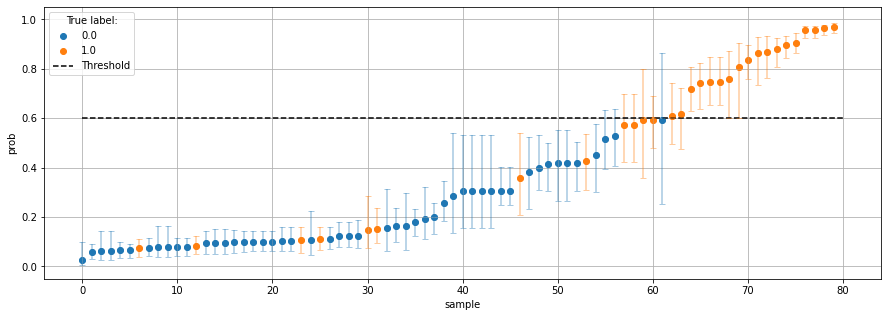

In [350]:
mb_lr.plot_predict(X_test, y_test, ci = 95, threshold = 0.6, n_samples = 80)